# A3: Predicting Car Price
## Task 1. Classification 
#### i:   make sure you used the preprocessed version of the dataset that you have done in A1/A2.
#### ii:  following the preprocessed version, convert the label selling price into discrete variable by simply
#### iii: put the price in a bucket of 0, 1, 2, 3 First.
###  a:   add a function accuracy which returns a single number as accuracy = correct predictions/all predictions
###  b:   add functions precision, recall, f1-score which calculates the score for each class. 
#####     Note that equation for each metric for an arbitrary class c as follows:
#####     precisionc =TPc / TPc + FPc
#####     recallc =TPc/ TPc + FNc
#####     f1c = 2 ∗ precisionc ∗ recallc / precisionc + recallc
######    where TP, TN, FN, FP are True Positives, True Negatives, False Negatives and False Positives respectively.
###  c:   add functions macro precision, macro recall and macro f1. Macro averaging simply averages the precision, recall, and f1 across all classes. 
###  d:   add functions weighted precision, weighted recall and weighted f1. Weighted averaging 
###  e:   last, try to run scikit-learn classification report and compare with your implementations. 
###  f    just a brief question here: what does support in the classification report means?

## Task 2. Ridge Logistic Regression - 
###       implement this penalty onto the code and allows users to choose whether to use the penalty or not

## Task 3. Deployment
###  a: Log your experiment to the CSIM mlflow server.
###  b: Deploy the Model using ‘Models’ module of the MLflow.
###  c: For the final touch, set up GitHub for CI/CD.


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import time
import pandas as pd

using the same datasaet as two previous assignment.

In [36]:
cars_data =pd.read_csv("cars.csv")
cars_data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


following are codes to prepare data to use, including removing strings from columns, some unwanted values and columns. adding age of cars instead of year of production (based on A1 instruction).

In [37]:
cars_data = cars_data[cars_data['fuel'].isin(['Petrol', 'Diesel'])]
cars_data.mileage = cars_data.mileage.str.split(expand=True)[0].astype(float)
cars_data.engine = cars_data.engine.str.split(expand=True)[0].astype(float)
cars_data.loc[cars_data['max_power'] == 'bph', 'max_power'] = ' bph'
cars_data.max_power = cars_data.max_power.str.split(expand=True)[0].astype(float)
cars_data = cars_data.drop(columns=['torque'])
cars_data = cars_data[cars_data['owner'] != 5]
from datetime import datetime
now = datetime.now()
cars_data['car_age'] = int(now.strftime("%Y")) - cars_data['year']

It seems that we have some features that can be encoded using one hot encoding.getting some hint from TA's take on A2, I looked at those features's values and encoded them by one hot method, but based on values and domain information i decided to keep just some values and also droped car's seat as i think it is not crucial in price estimation, engine as it has strong relation with max_power and mileage, and year. 

In [38]:
for col in ['fuel','seller_type','transmission', 'owner', 'seats']:  
    print(f"Column {col}: {len(cars_data[col].unique())} unique values: {cars_data[col].unique()}")

owner_coding = {'First Owner': 0,'Second Owner': 0, 'Third Owner': 0, 'Fourth & Above Owner': 0,'Test Drive Car': 1}
fuel_coding = {'Petrol' : 1, 'Diesel': 0 }
seller_coding = {'Individual' : 1,'Dealer' : 0,'Trustmark Dealer' : 0}
transmission_coding = {'Automatic' : 1, 'Manual' : 0}

cars_copy = cars_data.drop(['year','seats','engine'], axis = 1)

cars_copy['fuel'] = cars_copy['fuel'].map(fuel_coding)
cars_copy['owner'] = cars_copy['owner'].map(owner_coding)
cars_copy['seller_type'] = cars_copy['seller_type'].map(seller_coding)
cars_copy['transmission'] = cars_copy['transmission'].map(transmission_coding)
cars_copy.rename(columns = {'owner' : 'test_drive', 'fuel' : 'petrol_fuel', 'seller_type' : 'individual_seller', 'transmission' : 'is_automatic'}, inplace=True)    

Column fuel: 2 unique values: ['Diesel' 'Petrol']
Column seller_type: 3 unique values: ['Individual' 'Dealer' 'Trustmark Dealer']
Column transmission: 2 unique values: ['Manual' 'Automatic']
Column owner: 5 unique values: ['First Owner' 'Second Owner' 'Third Owner' 'Fourth & Above Owner'
 'Test Drive Car']
Column seats: 10 unique values: [ 5.  4. nan  7.  8.  6.  9. 10. 14.  2.]


In [39]:
cars_copy.head()

,name,selling_price,km_driven,petrol_fuel,individual_seller,is_automatic,test_drive,mileage,max_power,car_age
0,Maruti Swift Dzire VDI,450000,145500,0,1,0,0,23.40,74.00,9
1,Skoda Rapid 1.5 TDI Ambition,370000,120000,0,1,0,0,21.14,103.52,9
2,Honda City 2017-2020 EXi,158000,140000,1,1,0,0,17.70,78.00,17
3,Hyundai i20 Sportz Diesel,225000,127000,0,1,0,0,23.00,90.00,13
4,Maruti Swift VXI BSIII,130000,120000,1,1,0,0,16.10,88.20,16


In [40]:
cars_copy.describe().astype(int)

,selling_price,km_driven,petrol_fuel,individual_seller,is_automatic,test_drive,mileage,max_power,car_age
count,8033,8033,8033,8033,8033,8033,7819,7825,8033
mean,642736,69738,0,0,0,0,19,91,9
std,809863,56643,0,0,0,0,4,35,4
min,29999,1000,0,0,0,0,0,0,3
25%,260000,35000,0,1,0,0,16,69,6
50%,450000,60000,0,1,0,0,19,82,8
75%,680000,98000,1,1,0,0,22,102,12
max,10000000,2360457,1,1,1,1,42,400,40


to encode selling price to 4 classes label, firstly, I checked the histogram of the price. the distribution of selling price is highly skewed. the reason could be existing of different type of cars like luxury cars and ordinary cars, or icars from different categories like powerful cars and small cars, or some outliers. with this information cutting the values of selling price is not good idea because it may hide the pattern of labal and be be less informative. so I tried to explore the values by seeing histogram (here), and some tableau visuals (it could be uploaded). after some challenges,  I found some cutting points which may be better than equal categories. however, class imbalance should be considered in using classification scores.  

Text(0.5, 1.0, 'Histogram of cars selling price')

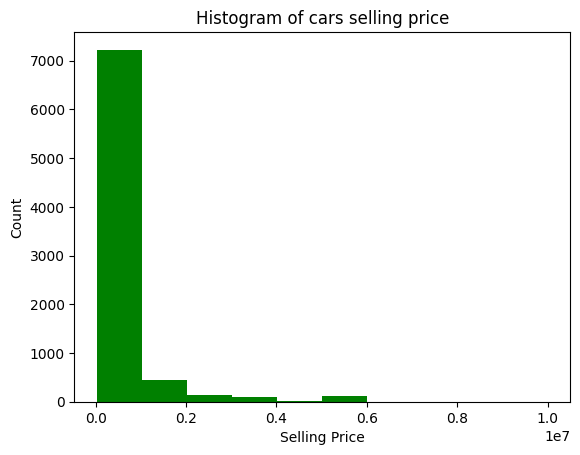

In [41]:

# the histogram of the data
plt.hist(cars_copy.selling_price, bins=10, facecolor='g')
plt.xlabel('Selling Price')
plt.ylabel('Count')
plt.title('Histogram of cars selling price')





In [42]:
cars_copy['price_level'] =  pd.cut(cars_copy['selling_price'], bins=[0, 300000, 750000, 1500000, 15000000], labels = [0, 1, 2, 3])
cars_copy['price_level'].value_counts(sort=False)


In [43]:
# creating 4 column for each class of y:
cars_copy['price_level']=cars_copy.price_level.astype(int)

cars_copy['price_level_0']= (1 * cars_copy.price_level==0).astype(int)
cars_copy['price_level_1']= (1 * cars_copy.price_level==1).astype(int)
cars_copy['price_level_2']= (1 * cars_copy.price_level==2).astype(int)
cars_copy['price_level_3']= (1 * cars_copy.price_level==3).astype(int)

In [47]:
#adding intercept to the data:
cars_copy['intercept']=1

In [48]:
# this code is not required for A3, I just put it here as I want to review and adjust my A1 again.
def log_func(x):
    return np.log(x)

cars_copy['ln_price'] = cars_copy['selling_price'].apply(log_func)


In [49]:
# reordering the columns (optional) but I like to have y's and x's in order.
cars_copy=cars_copy.reindex(['name','selling_price','ln_price','price_level','price_level_0','price_level_1','price_level_2','price_level_3','intercept',
                              'km_driven','mileage','max_power','car_age','petrol_fuel','individual_seller','test_drive','is_automatic'],axis=1)

I think outlier diagnosing can effect the feature selection so I did this step before feature selection phase. these tresholds were found by trail and error, i checked different set of values like Q75, median ,...) and at the end chose these cutting point. after further data examination, I founf that these outlier values belpongs to some special cars, like very old, very powerful, ... so keeping these values in the data set can effect the accuracy of prediction because pricing of special cars does not follow the general rule of second hand cars pricing. after removing outliers luckily all missing values were also removed.

In [51]:
# first I created a new df without some outliers:
cars_copy_out = cars_copy.loc[cars_copy['km_driven'] < 190000]
# I droped other outliers  based on different features from the new df cars_copy_out: 
cars_copy_out = cars_copy_out.loc[cars_copy_out['max_power'] < 200]
cars_copy_out = cars_copy_out.loc[cars_copy_out['car_age'] < 20]
cars_copy_out = cars_copy_out.loc[cars_copy_out['mileage'] < 30]

In [52]:
cars_copy_out.describe()

,selling_price,ln_price,price_level,price_level_0,price_level_1,price_level_2,price_level_3,intercept,km_driven,mileage,max_power,car_age,petrol_fuel,individual_seller,test_drive,is_automatic
count,7.444000e+03,7444.000000,7444.000000,7444.000000,7444.000000,7444.000000,7444.000000,7444.0,7444.000000,7444.000000,7444.000000,7444.000000,7444.000000,7444.000000,7444.000000,7444.000000
mean,6.275962e+05,13.014027,0.949624,0.298764,0.513031,0.128023,0.060183,1.0,64751.964804,19.553581,90.692634,8.749194,0.451370,0.826975,0.000672,0.127082
std,7.196087e+05,0.774984,0.815518,0.457747,0.499864,0.334137,0.237841,0.0,39623.501155,3.936885,32.247782,3.484920,0.497663,0.378295,0.025910,0.333087
min,3.150400e+04,10.357870,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1000.000000,0.000000,34.200000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,2.750000e+05,12.524526,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,32457.750000,16.950000,69.000000,6.000000,0.000000,1.000000,0.000000,0.000000
50%,4.599990e+05,13.038980,1.000000,0.000000,1.000000,0.000000,0.000000,1.0,60000.000000,19.490000,82.000000,8.000000,0.000000,1.000000,0.000000,0.000000
75%,6.900000e+05,13.444447,1.000000,1.000000,1.000000,0.000000,0.000000,1.0,90000.000000,22.320000,102.000000,11.000000,1.000000,1.000000,0.000000,0.000000
max,6.523000e+06,15.690845,3.000000,1.000000,1.000000,1.000000,1.000000,1.0,189000.000000,28.400000,198.500000,19.000000,1.000000,1.000000,1.000000,1.000000


In [53]:
# after removing outliers the count of y values are as follows:
cars_copy_out['price_level'].value_counts(sort = False)

price_level
1    3819
0    2224
2     953
3     448
Name: count, dtype: int64

by exploring scatter plots of all feature by all y classes we can underestand something about the features. among all features it seems that petrol_fuel, individual_seller, and test_drive are not suitable becuase they have few points in some levels of y. so I decided to ignore those features. other features seems effective according to seperation of y classes.

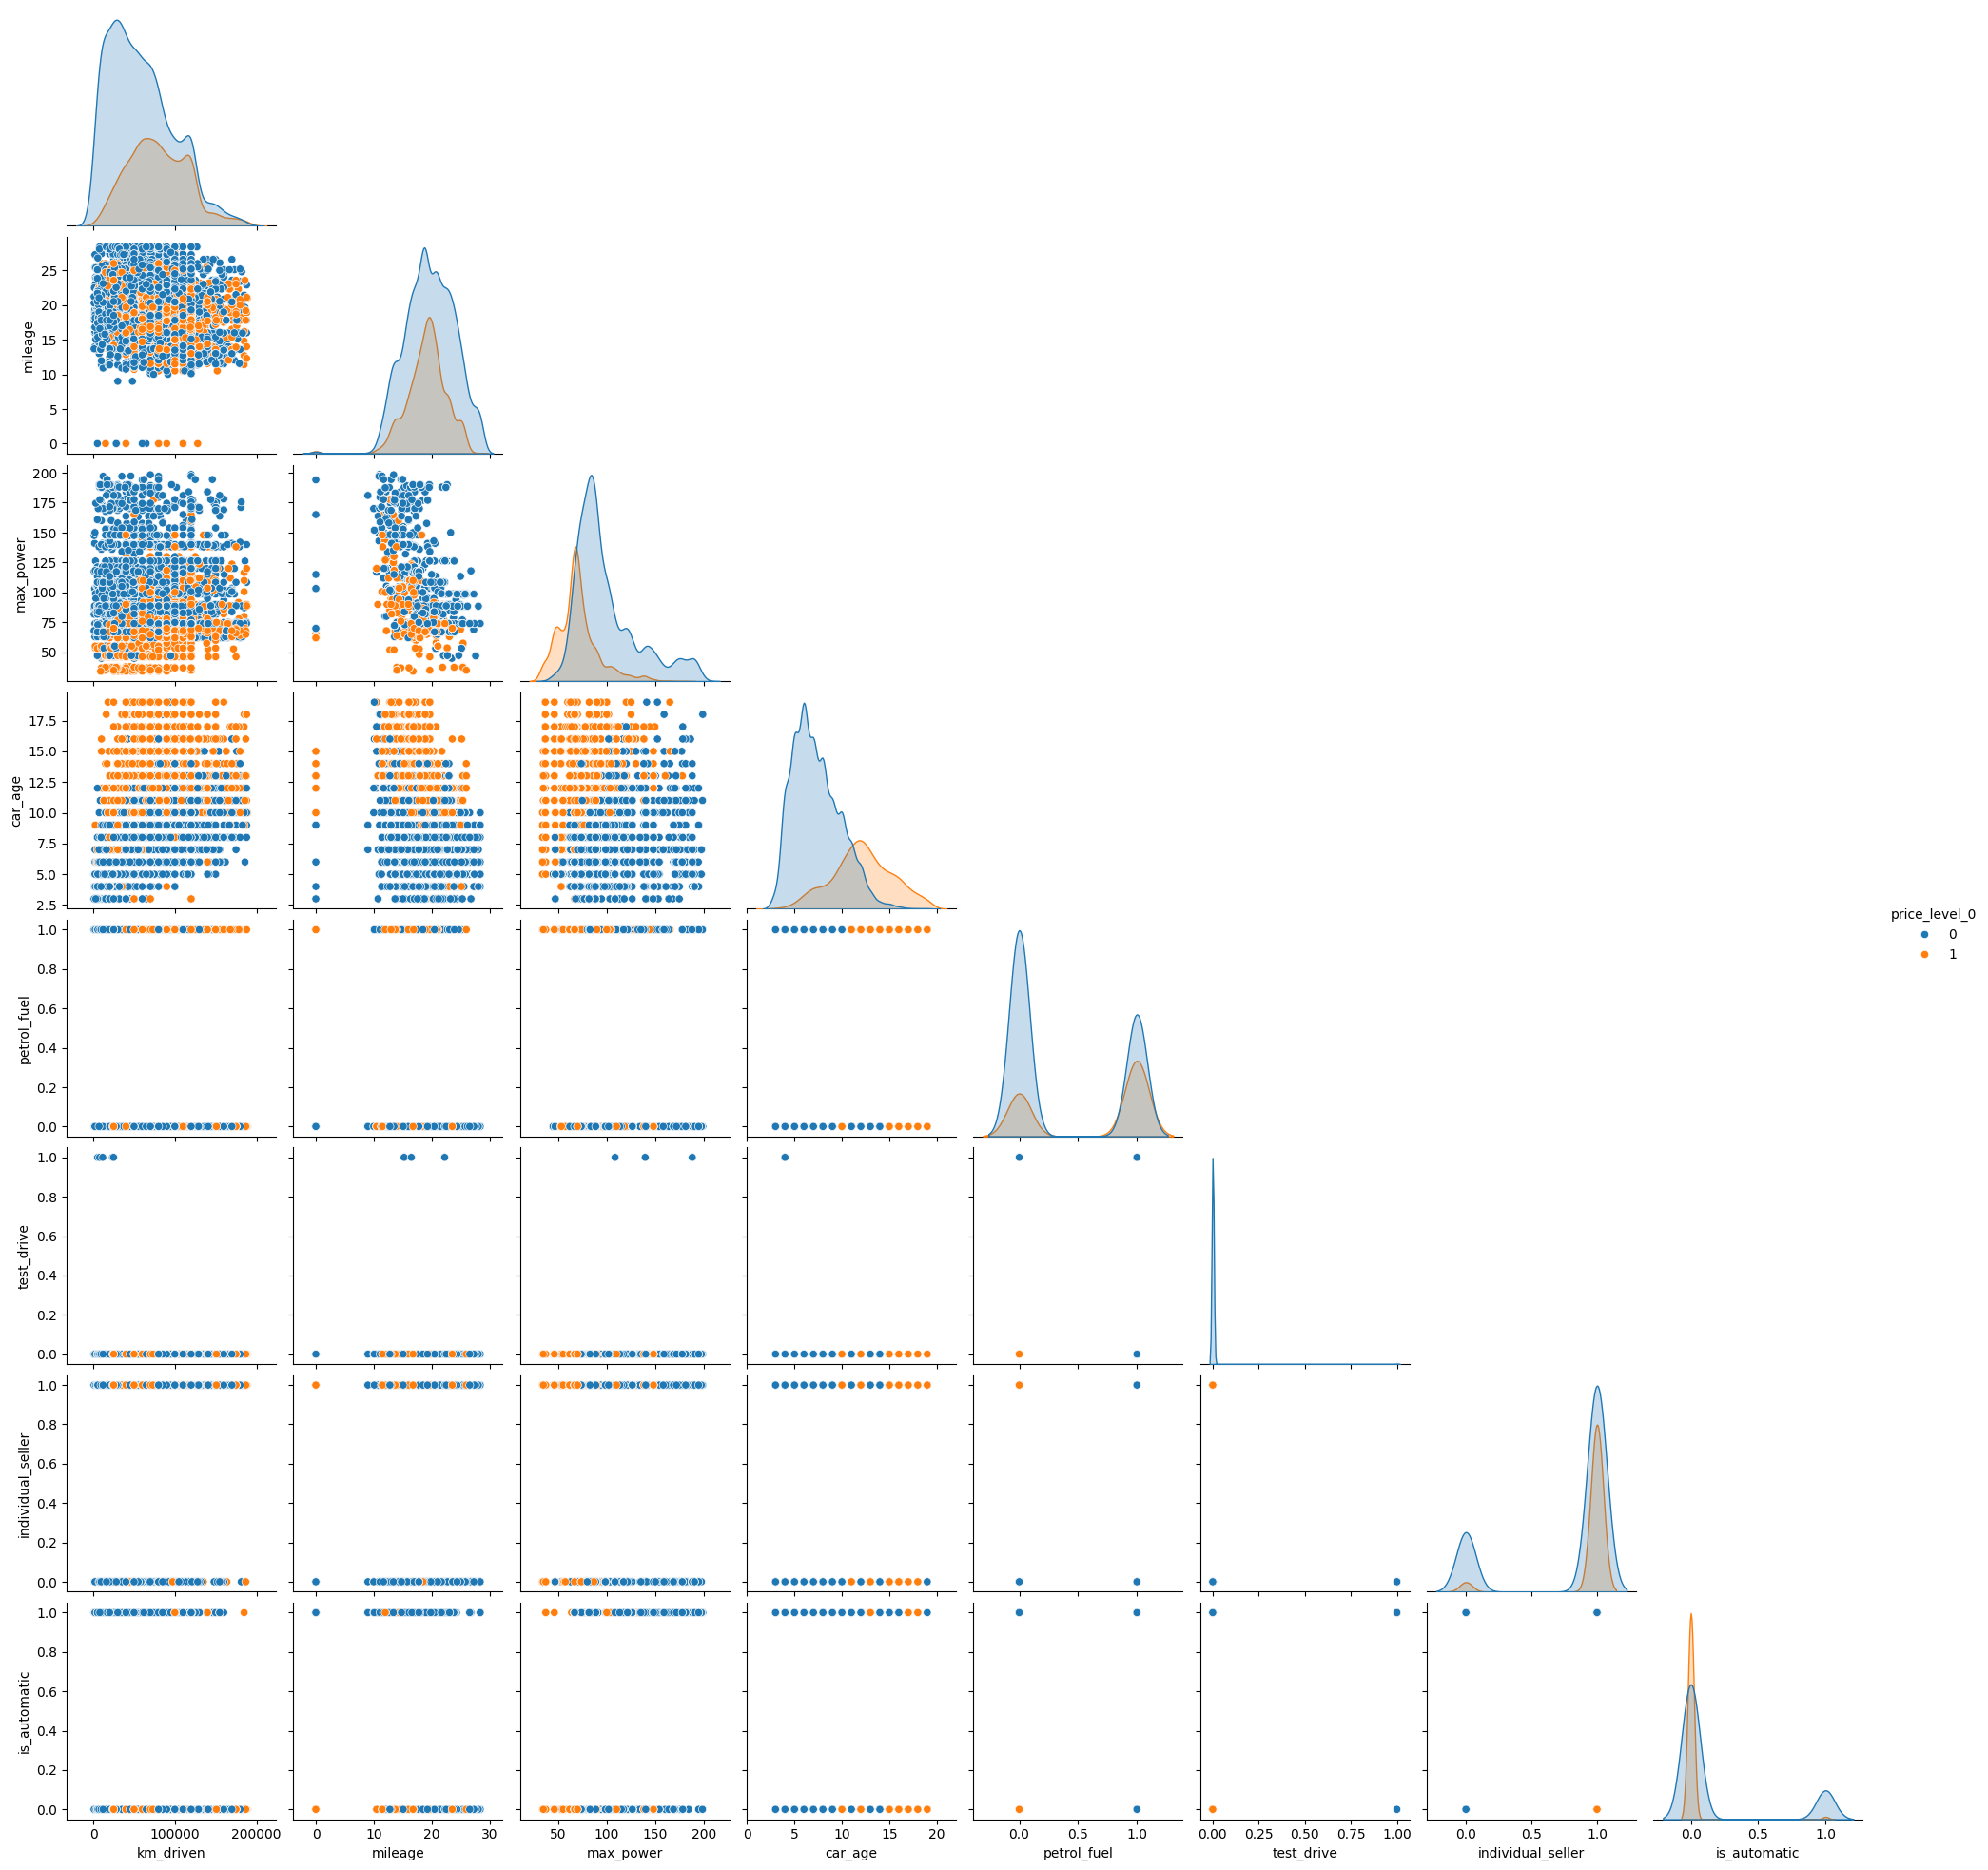

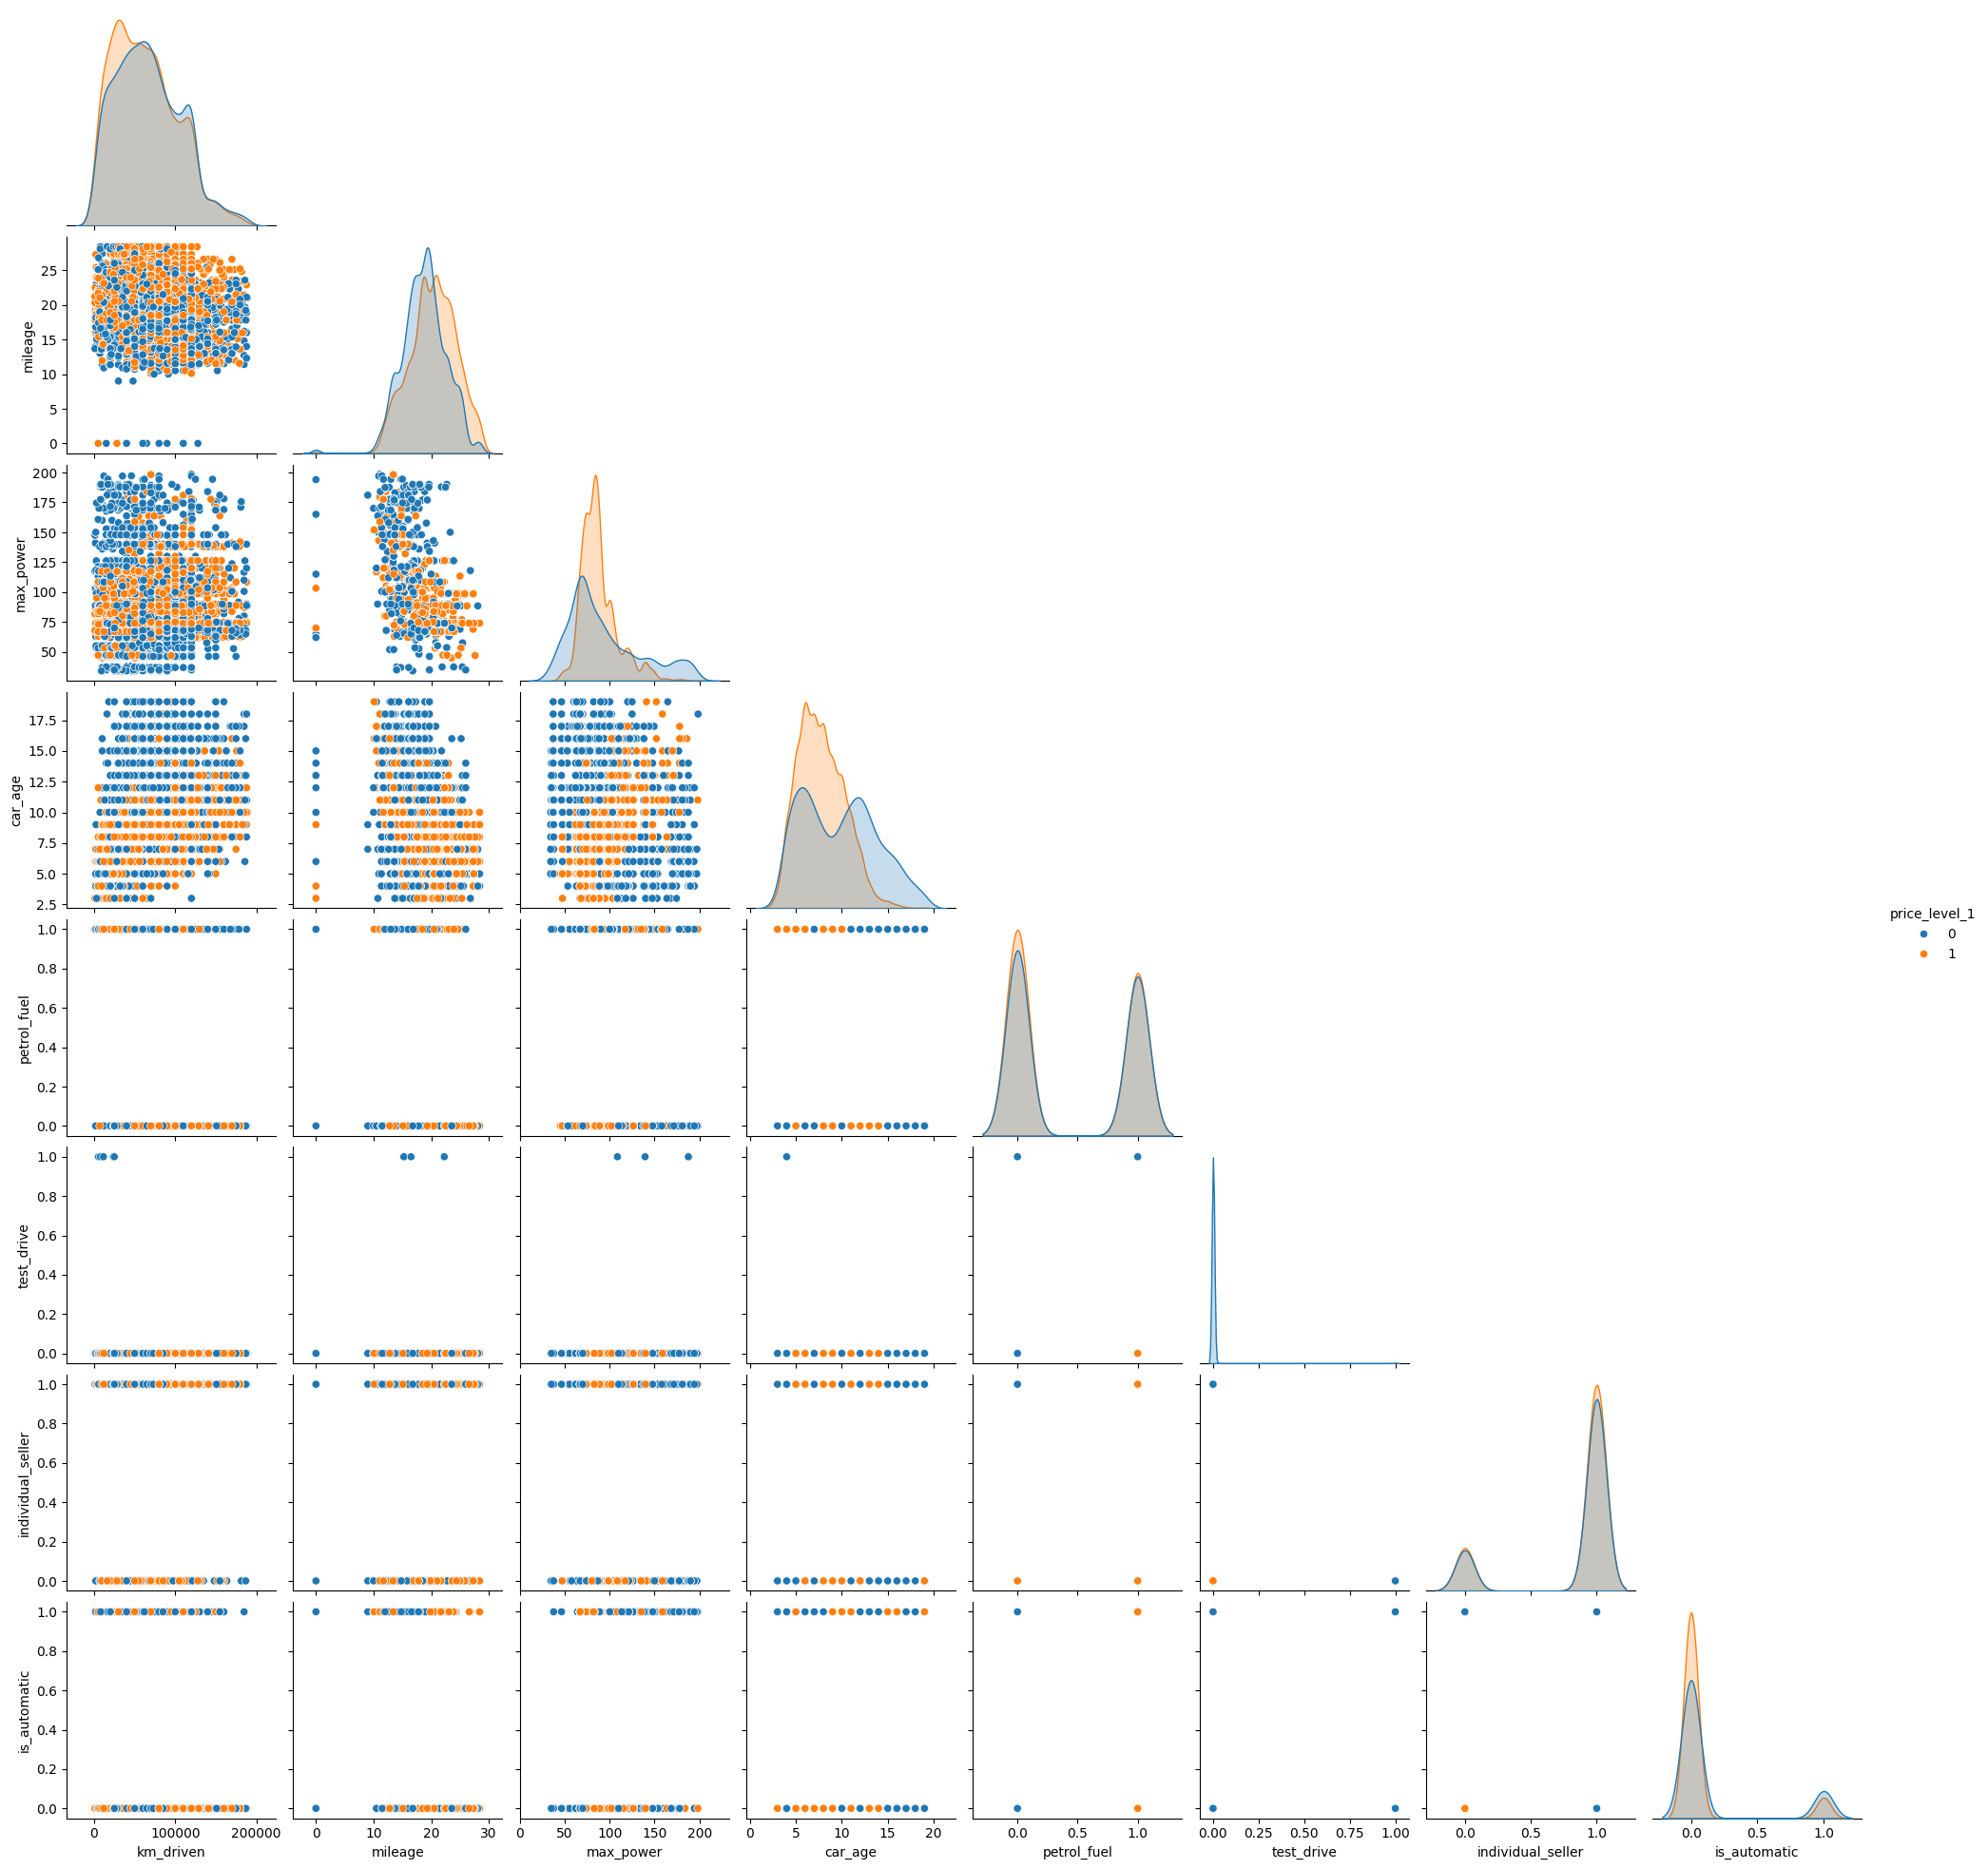

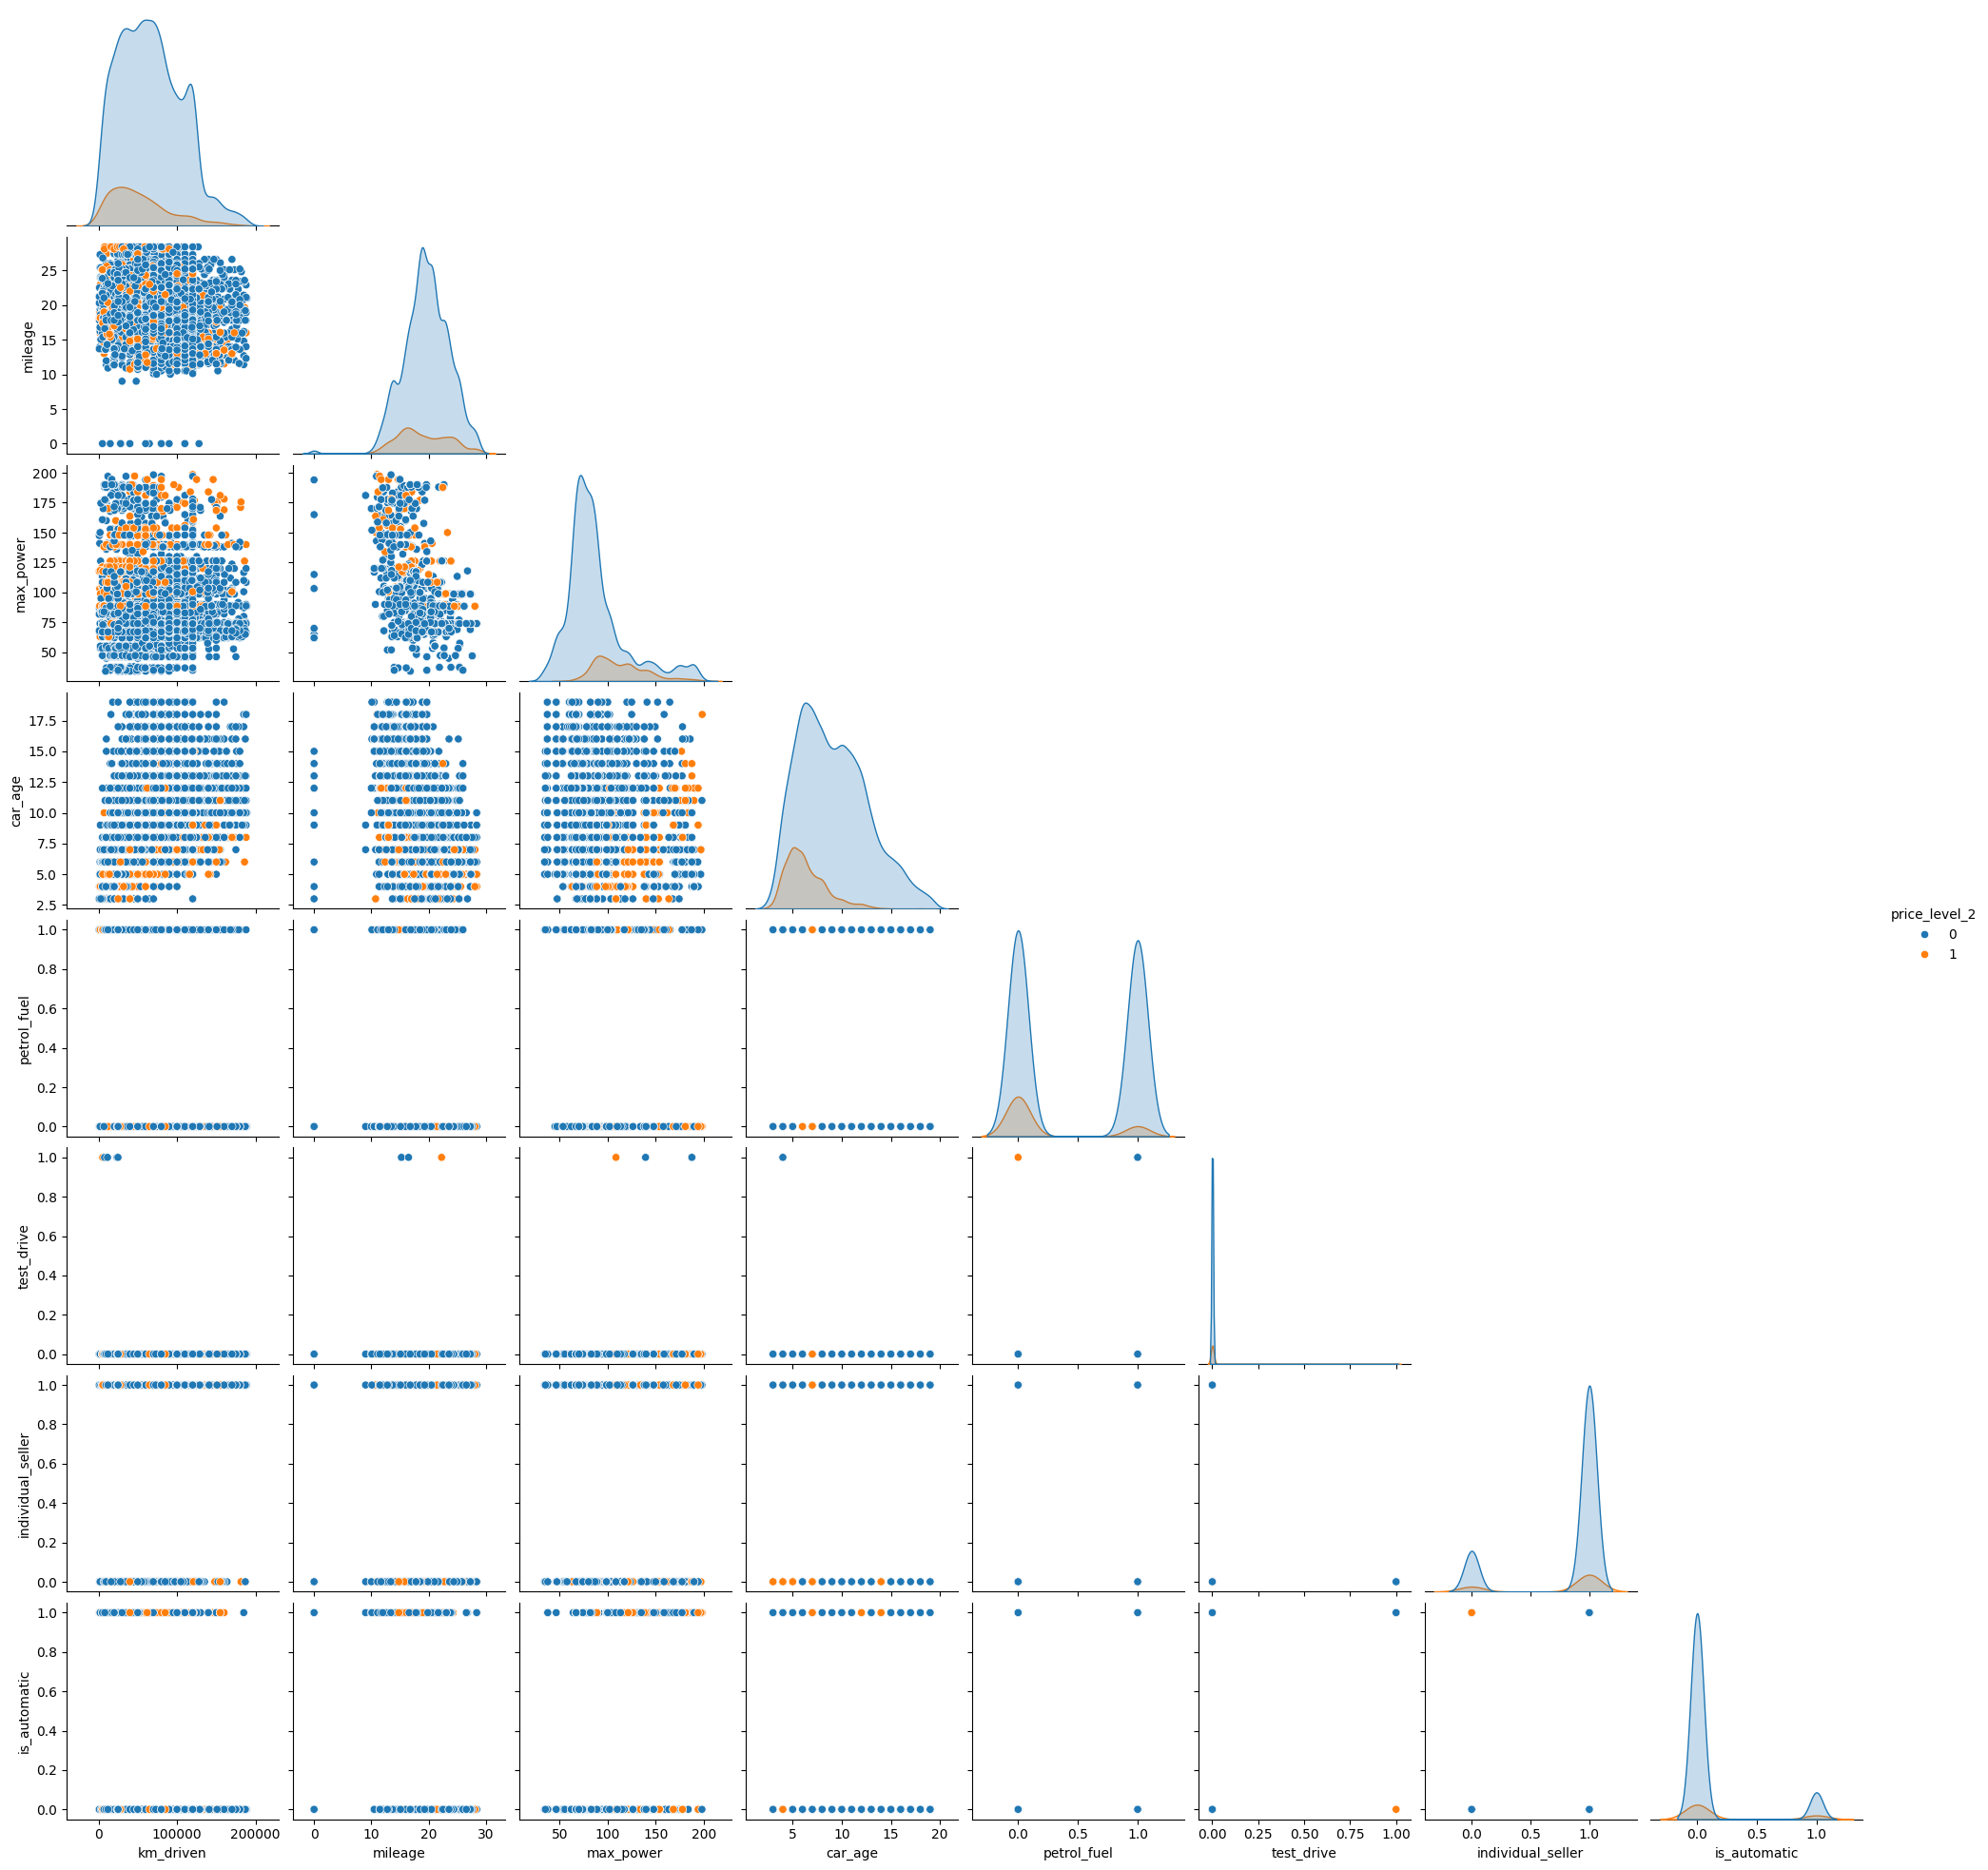

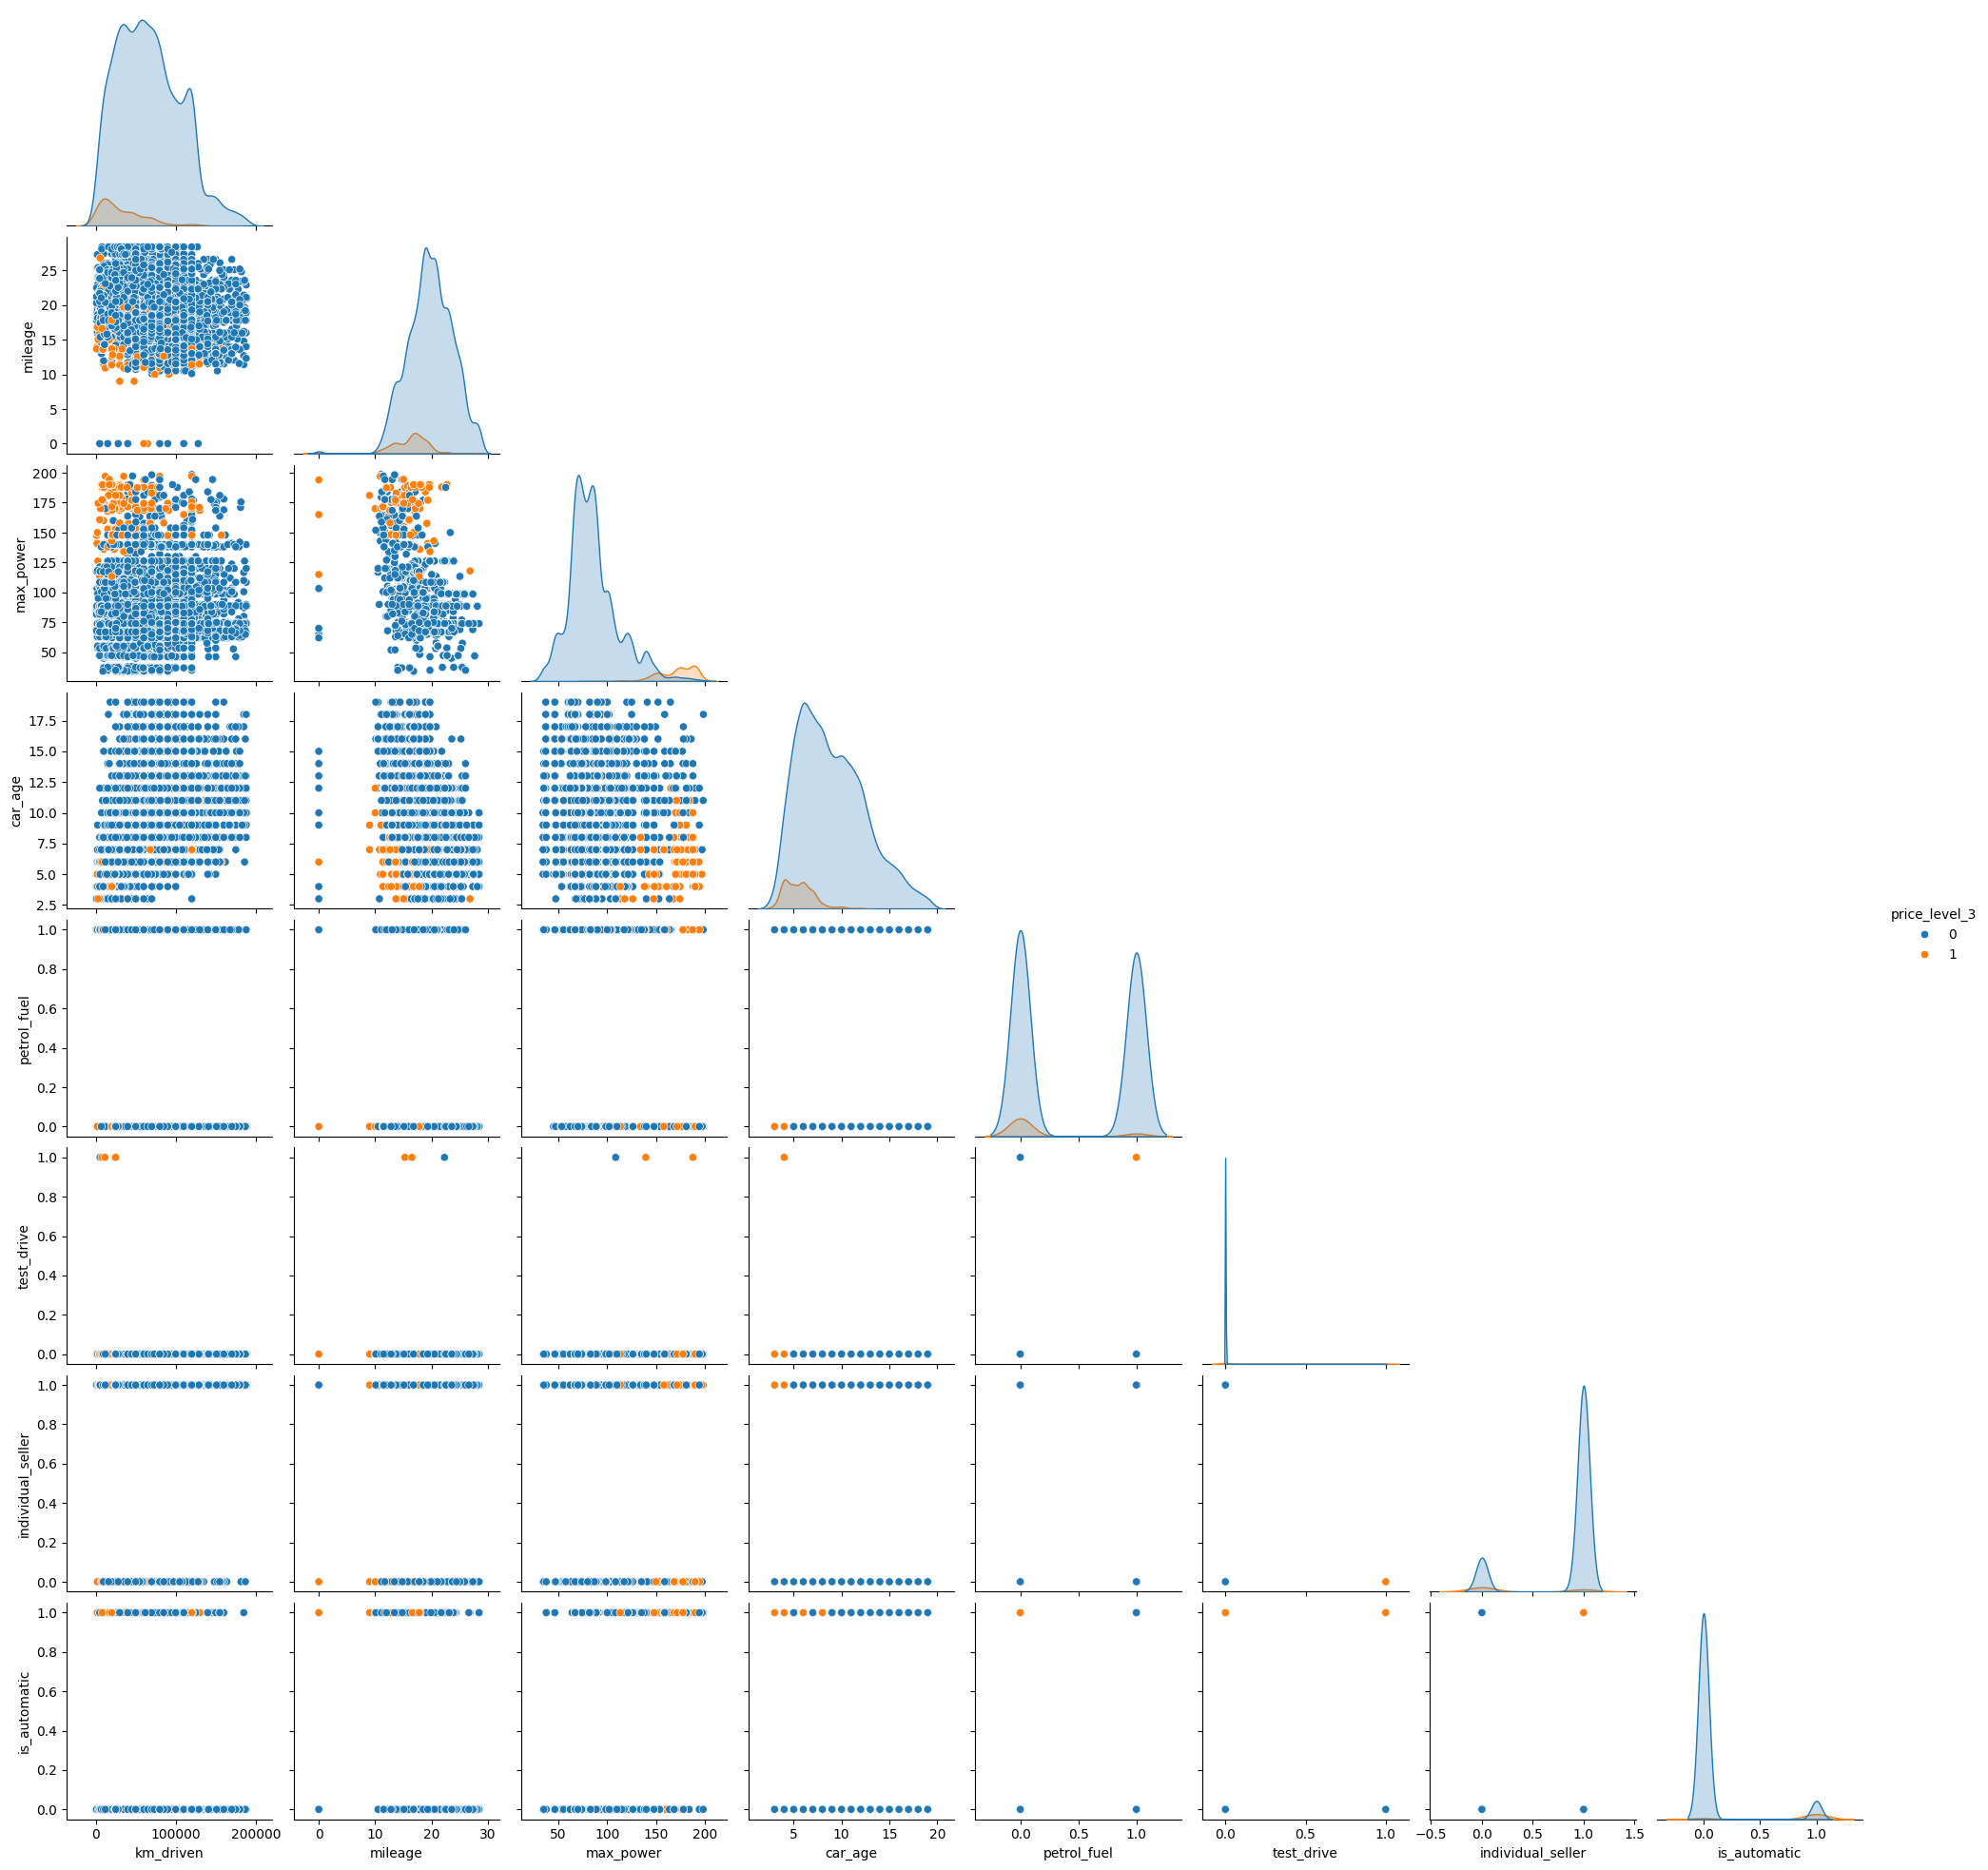

In [55]:
import seaborn as sns
sns.pairplot(data = cars_copy_out,vars= ['km_driven','mileage','max_power', 'car_age',
                                         'petrol_fuel', 'test_drive', 'individual_seller', 'is_automatic'],hue='price_level_0', corner = True)
plt.show()

sns.pairplot(data = cars_copy_out,vars= ['km_driven','mileage','max_power', 'car_age',
                                         'petrol_fuel', 'test_drive','individual_seller', 'is_automatic'],hue='price_level_1', corner = True)
plt.show()

sns.pairplot(data = cars_copy_out,vars= ['km_driven','mileage','max_power', 'car_age',
                                         'petrol_fuel', 'test_drive','individual_seller', 'is_automatic'],hue='price_level_2', corner = True)
plt.show()

sns.pairplot(data = cars_copy_out,vars= ['km_driven','mileage','max_power', 'car_age',
                                         'petrol_fuel', 'test_drive','individual_seller', 'is_automatic'],hue='price_level_3', corner = True)
plt.show()

In [56]:
# as a final decision 6 features were selected. based on that following codes creates Y and X respectively.
Y = cars_copy_out[['price_level_0','price_level_1', 'price_level_2', 'price_level_3']]
X = cars_copy_out.drop(columns = ['name','selling_price','ln_price','price_level','price_level_0','price_level_1', 'price_level_2', 'price_level_3',
                                  'test_drive','individual_seller','petrol_fuel'])
X.shape, Y.shape

((7444, 6), (7444, 4))

In [57]:
#creating train and test sets:
from sklearn.model_selection import train_test_split
X_train,  X_test, Y_train, Y_test = train_test_split(X , Y, test_size = 0.30, random_state=370)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((5210, 6), (2234, 6), (5210, 4), (2234, 4))

imputation should be done after splititing data to test and train because we shoul not touch the test set. here all features are complete and they do not have any missing values. actually they have rempoved along with outliers but we didn't use any distribution and hence data leakage might not happen.

In [58]:
X_train.isna().sum(), X_test.isna().sum()

(intercept       0
 km_driven       0
 mileage         0
 max_power       0
 car_age         0
 is_automatic    0
 dtype: int64,
 intercept       0
 km_driven       0
 mileage         0
 max_power       0
 car_age         0
 is_automatic    0
 dtype: int64)

Scalling features for train  and test set:
scalling was done based on the distribution of features. for km_driven and max_power I used normalization and for the mileage and car_age used standardization.

In [59]:
denum_km_driven = X_train['km_driven'].max()-X_train['km_driven'].min()
num_km_driven = X_train['km_driven']-X_train['km_driven'].min()
X_train['km_driven'] = num_km_driven/denum_km_driven

denum_max_power = X_train['max_power'].max()-X_train['max_power'].min()
num_max_power = X_train['max_power']-X_train['max_power'].min()
X_train['max_power'] = num_max_power/denum_max_power

X_train['mileage'] = (X_train['mileage'] - X_train['mileage'].mean()) / X_train['mileage'].std()
X_train['car_age'] = (X_train['car_age'] - X_train['car_age'].mean()) / X_train['car_age'].std()

In [60]:
X_train.head()

,intercept,km_driven,mileage,max_power,car_age,is_automatic
1305,1,0.526596,0.214111,0.272063,1.508961,0
2643,1,0.294096,1.132515,0.242057,-0.790198,0
3209,1,0.260638,-0.482262,0.692270,-0.790198,0
4147,1,0.047872,0.012263,0.289714,-1.364988,1
361,1,0.356383,-1.264420,0.689592,0.359382,1


In [61]:
denum_km_driven = X_test['km_driven'].max()-X_test['km_driven'].min()
num_km_driven = X_test['km_driven']-X_test['km_driven'].min()
X_test['km_driven'] = num_km_driven/denum_km_driven

denum_max_power = X_test['max_power'].max()-X_test['max_power'].min()
num_max_power = X_test['max_power']-X_test['max_power'].min()
X_test['max_power'] = num_max_power/denum_max_power

X_test['mileage'] = (X_test['mileage'] - X_test['mileage'].mean()) / X_test['mileage'].std()
X_test['car_age'] = (X_test['car_age'] - X_test['car_age'].mean()) / X_test['car_age'].std()

I modified these codes to compute all requested metrics and L2 regularization.

In [62]:
class LogisticRegression:
    
    def __init__(self, k, n, method, alpha = 0.001, max_iter=5000, ridge_l=0.0):
        self.k = k
        self.n = n
        self.alpha = alpha
        self.max_iter = max_iter
        self.method = method
        self.ridge_l = ridge_l
    
    def fit(self, X, Y):
        self.W = np.random.rand(self.n, self.k) 
        self.losses = []
                
        if self.method == "batch":
            start_time = time.time()
            for i in range(self.max_iter):
                loss, grad =  self.gradient(X, Y)
                self.losses.append(loss)
                self.W = self.W - self.alpha * grad
                if i % 1000 == 0:
                    print(f"Loss at iteration {i}:", loss)
            print(f"time taken: {time.time() - start_time}")
            
        elif self.method == "minibatch":
            start_time = time.time()
            batch_size = int(0.3 * X.shape[0])
            for i in range(self.max_iter):
                ix = np.random.randint(0, X.shape[0]) #<----with replacement
                batch_X = X[ix:ix+batch_size]
                batch_Y = Y[ix:ix+batch_size]
                loss, grad = self.gradient(batch_X, batch_Y)
                self.losses.append(loss)
                self.W = self.W - self.alpha * grad
                if i % 1000 == 0:
                    print(f"Loss at iteration {i}:", loss)
            print(f"time taken: {time.time() - start_time}")
            
        elif self.method == "sto":
            start_time = time.time()
            list_of_used_ix = []
            for i in range(self.max_iter):
                idx = np.random.randint(X.shape[0])
                while i in list_of_used_ix:
                    idx = np.random.randint(X.shape[0])
                X_train = X[idx, :].reshape(1, -1)
                Y_train = Y[idx]
                loss, grad = self.gradient(X_train, Y_train)
                self.losses.append(loss)
                self.W = self.W - self.alpha * grad
                
                list_of_used_ix.append(i)
                if len(list_of_used_ix) == X.shape[0]:
                    list_of_used_ix = []
                if i % 1000 == 0:
                    print(f"Loss at iteration {i}:", loss)
            print(f"time taken: {time.time() - start_time}")
            
        else:
            raise ValueError('Method must be one of the followings: "batch", "minibatch" or "sto".')
        
        
    def gradient(self, X, Y):
        m = X.shape[0]
        h = self.h_theta(X, self.W)
        loss = - np.sum(Y*np.log(h)) / m
        error = h - Y
        ############################### modification to add l2 regularization + adding ridge_l to parameters ######################
        grad = self.softmax_grad(X, error) + self.ridge_l * np.sum(np.square(self.W))
        return loss, grad

    def softmax(self, theta_t_x):
        return np.exp(theta_t_x) / np.sum(np.exp(theta_t_x), axis=1, keepdims=True)

    def softmax_grad(self, X, error):
        return  X.T @ error

    def h_theta(self, X, W):
        '''
        Input:
            X shape: (m, n)
            w shape: (n, k)
        Returns:
            yhat shape: (m, k)
        '''
        return self.softmax(X @ W)
    
    def predict(self, X_test):
        return np.argmax(self.h_theta(X_test, self.W), axis=1)
    ####################### modified parts for extra metrics: ################################################
    def accuracy(self, y_test, yhat):
        correct_predictions = np.sum(y_test == yhat)
        all_predictions = len(y_test)
        return correct_predictions / all_predictions
    
    def precision(self, y_test, yhat, class_idx):
        tp = np.sum((y_test == class_idx) & (yhat == class_idx))
        fp = np.sum((y_test != class_idx) & (yhat == class_idx))
        return tp / (tp + fp)

    def recall(self, y_test, yhat, class_idx):
        tp = np.sum((y_test == class_idx) & (yhat == class_idx))
        fn = np.sum((y_test == class_idx) & (yhat != class_idx))
        return tp / (tp + fn)

    def f1_score(self, y_test, yhat, class_idx):
        precision = self.precision(y_test, yhat, class_idx)
        recall = self.recall(y_test, yhat, class_idx)
        return 2 * (precision * recall) / (precision + recall)
    
    def macro_precision(self, y_test, yhat):
        num_classes = len(np.unique(y_test))
        precisions = []
        for class_idx in range(num_classes):
            precision = self.precision(y_test, yhat, class_idx)
            precisions.append(precision)
        return np.mean(precisions)

    def macro_recall(self, y_test, yhat):
        num_classes = len(np.unique(y_test))
        recalls = []
        for class_idx in range(num_classes):
            recall = self.recall(y_test, yhat, class_idx)
            recalls.append(recall)
        return np.mean(recalls)

    def macro_f1_score(self, y_test, yhat):
        macro_precision = self.macro_precision(y_test, yhat)
        macro_recall = self.macro_recall(y_test, yhat)
        return 2 * (macro_precision * macro_recall) / (macro_precision + macro_recall)

    def weighted_precision(self, y_test, yhat):
        num_classes = len(np.unique(y_test))
        weights = np.bincount(y_test) / len(y_test)
        precisions = []
        for class_idx in range(num_classes):
            precision = self.precision(y_test, yhat, class_idx)
            precisions.append(precision * weights[class_idx])
        return np.sum(precisions)

    def weighted_recall(self, y_test, yhat):
        num_classes = len(np.unique(y_test))
        weights = np.bincount(y_test) / len(y_test)
        recalls = []
        for class_idx in range(num_classes):
            recall = self.recall(y_test, yhat, class_idx)
            recalls.append(recall * weights[class_idx])
        return np.sum(recalls)

    def weighted_f1_score(self, y_test, yhat):
        weighted_precision = self.weighted_precision(y_test, yhat)
        weighted_recall = self.weighted_recall(y_test, yhat)
        return 2 * (weighted_precision * weighted_recall) / (weighted_precision + weighted_recall)
############################end of modified part for extrea metrics ############################
    def plot(self):
        plt.plot(np.arange(len(self.losses)) , self.losses, label = "Train Losses")
        plt.title("Losses")
        plt.xlabel("epoch")
        plt.ylabel("losses")
        plt.legend()

In [63]:
# changing pandas dfs to numpy because the program needs numpy objects as an input:
X_train_nm = X_train.to_numpy()
Y_train_nm = Y_train.to_numpy()
X_test_nm = X_test.to_numpy()
Y_test_nm = Y_test.to_numpy()


In [64]:
k = Y_train_nm.shape[1]  # no. of classes  
m = X_train_nm.shape[0]  # no.of samples
n = X_train_nm.shape[1]
k,m,n

(4, 5210, 6)

In [65]:
# creating one column y_test to be used in model prediction:
y_test =0 * Y_test['price_level_0']+1 * Y_test['price_level_1']+ 2 * Y_test['price_level_2']+3 * Y_test['price_level_3']
y_test.value_counts()

1    1143
0     677
2     284
3     130
Name: count, dtype: int64

In [66]:
model = LogisticRegression(k, n, "minibatch", alpha=0.001, ridge_l=0.001)
model.fit(X_train_nm, Y_train_nm)
yhat = model.predict(X_test_nm)
model.accuracy(y_test,yhat)
print("="*10, "Classification report" ,"="*10)
print("accuracy", "="*20) 
print("accuracy: ", f"{model.accuracy(y_test, yhat): .2f}")

print("precision", "="*20)
for class_idx in range(k):
    print("precision for class_idx:",class_idx, f"{model.precision(y_test, yhat, class_idx): .2f}")
print("macro precision: ", f"{model.macro_precision(y_test, yhat): .2f}")
print("weighted precision: ", f"{model.weighted_precision(y_test, yhat): .2f}") 
 
print("recall", "="*20)  
for class_idx in range(k):
    print("recall for class_idx:",class_idx, f"{model.recall(y_test, yhat, class_idx): .2f}")
print("macro recall: ", f"{model.macro_recall(y_test, yhat): .2f}")
print("weighted recall: ", f"{model.weighted_recall(y_test, yhat): .2f}")

print("f1 score", "="*20)   
for class_idx in range(k):
    print("f1 score for class_idx:",class_idx, f"{model.f1_score(y_test, yhat, class_idx): .2f}")    
print("macro f1 score: ", f"{model.macro_f1_score(y_test, yhat): .2f}")
print("weighted f1 score: ", f"{model.weighted_f1_score(y_test, yhat): .2f}")          

Loss at iteration 0: 1.614888921731339
Loss at iteration 1000: 0.5564966486786718
Loss at iteration 2000: 0.5243860705585269
Loss at iteration 3000: 0.5144059554443924
Loss at iteration 4000: 0.5090976284806511
time taken: 0.7046687602996826
========== Classification report ==========
accuracy ====================
accuracy:   0.79
precision ====================
precision for class_idx: 0  0.84
precision for class_idx: 1  0.77
precision for class_idx: 2  0.68
precision for class_idx: 3  0.86
macro precision:   0.79
weighted precision:   0.79
recall ====================
recall for class_idx: 0  0.80
recall for class_idx: 1  0.87
recall for class_idx: 2  0.39
recall for class_idx: 3  0.88
macro recall:   0.74
weighted recall:   0.79
f1 score ====================
f1 score for class_idx: 0  0.82
f1 score for class_idx: 1  0.82
f1 score for class_idx: 2  0.49
f1 score for class_idx: 3  0.87
macro f1 score:   0.76
weighted f1 score:   0.79


Task 3: part 1 and part2: puting model in the csim mlflow server:  i tried models with differnt parameters but there were not any significant changes in the metrics. as we have class imbalance accuracy is not good metric and we should use other metrics like precision and recall. furthermore there is no difference between FN and FP so I think using f1 score is the best scenario. 
### support: I think this is the number of values in each class. we can see the metric is computed based on haw many examples.

In [67]:
import mlflow
import os
mlflow.set_tracking_uri("https://mlflow.cs.ait.ac.th/")
os.environ["LOGNAME"] = "Reza"
mlflow.set_experiment(experiment_name="st123122_a3")

<Experiment: artifact_location='mlflow-artifacts:/263346252026780827', creation_time=1696266138993, experiment_id='263346252026780827', last_update_time=1696266138993, lifecycle_stage='active', name='st123122_a3', tags={}>

In [68]:
params = {"k" : 4, "n" : 6, "method": "minibatch", "alpha": 0.001, "max_iter" : 10000, "ridge_l": 0.001}
   
with mlflow.start_run(run_name=f"{'Multinomial Logistic regression'}-method:{params['method']}-lr:{params['alpha']}-L2_regularization:{params['ridge_l']}", nested=True,description = 
"label is car's price levels, features are: km_driven, mileage, max_power, car_age, petrol_fuel, individual_seller, test_drive, is_automatic"):
    
    mlflow.log_param("learning_rate", params["alpha"])
    mlflow.log_param("method", params["method"])
    mlflow.log_param("ridge regularization rate", params["ridge_l"])
    mlflow.log_param("maximum iteration", params["max_iter"])
    model = LogisticRegression(**params)
    model.fit(X_train_nm, Y_train_nm)

  
    mlflow.sklearn.log_model(model, "st123122- a3 model")

    
    mlflow.log_metric("01_accuracy", model.accuracy(y_test, yhat))
    mlflow.log_metric("02_precision", model.precision(y_test, yhat, class_idx))
    mlflow.log_metric("03_macro precision", model.macro_precision(y_test, yhat))
    mlflow.log_metric("04_weighted precision", model.weighted_precision(y_test, yhat))
    mlflow.log_metric("05_recall", model.recall(y_test, yhat, class_idx))
    mlflow.log_metric("06_macro recall", model.macro_recall(y_test, yhat))
    mlflow.log_metric("07_weighted recall", model.weighted_recall(y_test, yhat))
    mlflow.log_metric("08_f1 score", model.f1_score(y_test, yhat, class_idx))
    mlflow.log_metric("09_macro f1 score", model.macro_f1_score(y_test, yhat))
    mlflow.log_metric("10_weighted f1 score", model.weighted_f1_score(y_test, yhat))
mlflow.end_run()    

Loss at iteration 0: 1.4534568181889018
Loss at iteration 1000: 0.5424948881440175
Loss at iteration 2000: 0.5280496880265202
Loss at iteration 3000: 0.5199521760785755
Loss at iteration 4000: 0.5143843572681821
Loss at iteration 5000: 0.4990277827624125
Loss at iteration 6000: 0.5177183595740298
Loss at iteration 7000: 0.4968233764944061
Loss at iteration 8000: 0.5125081361257112
Loss at iteration 9000: 0.5108788499216966
time taken: 1.4380905628204346


/usr/local/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
